# Librerias

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
from datetime import datetime
import pickle
import os


import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_privacy

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

from tensorflow.keras.models import model_from_json
#from tensorflow_privacy import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer




In [2]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdagradOptimizer

In [3]:
import tensorflow
print(tensorflow.__version__)


2.15.0


In [4]:
import tensorflow_privacy
print(tensorflow_privacy.__version__)


0.5.1


# Abrir Datos

In [5]:
seno = pd.read_excel("Seno_freq_30_amplitud_10_ruido3.xlsx")

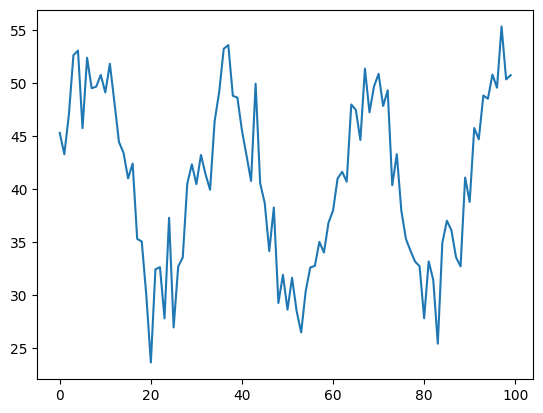

In [6]:
plt.plot(seno[:100])

# Crear Funciones

## LSTM_TFP

In [7]:

# X_train va a ser: (len(Datos) - ventana - prediccion ) * test_size

# batch debe ser múltiplo de X_train.shape[0]
# micro batch debe ser múltiplo de batch 
# de donde sale el número abajo de época cuando corro el modelo? 
# número de batches que el modelo procesa en cada época.
# se calcula como X_train.shape[0] * (1-Val_size) / batch



In [8]:

def LSTM_TFP_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,norm_clip,ruido,microBatches,lr,size_test,size_val,nombre):
    

    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    print("Batch debe ser divisor de ", round((len(datos) - ventana - prediccion)* (1- size_test),1 ))

    # batch debe ser divisor de X_train.shape[0]
    
    if X_train.shape[0] % batch == 0:
        print(f"El batch {batch} si sirve para el X_train {X_train.shape[0]}")
    else:
        print("No Va a servir")
    #raise ValueError('Batch  No es divisor de X_Train')



    # # micro batch debe ser múltiplo de batch 

    if batch % microBatches != 0:
        raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    else:
        print("El MicroBatch si es múltiplo del batch")



    # # X_train.shape[0] * (1-Val_size) / micro_batch debe ser entero. 

    if X_train.shape[0] * (1-size_val) % microBatches == 0:
        print("X_train.shape[0] * (1-Val_size) / micro_batch es entero, va a servir.")
    else:
        print("No va a servir porque X_train.shape[0] * (1-Val_size) / micro_batch debe ser entero")


    



    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


    model = Sequential()

    model.add(LSTM(nodos1,activation= activacion1, input_shape=(ventana,1)))
    model.add(Dense(nodos2, activation=activacion2))
    model.add(Dense(prediccion , activation=activacion3))






    # agregar la privacidad diferencial en el optimizador 
    optimizer = DPKerasAdamOptimizer(
        l2_norm_clip=norm_clip,
        noise_multiplier=ruido,
        num_microbatches=microBatches,
        learning_rate=lr)

    # Función de pérdida para regresión
    loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)

    #directorio = "mi_directorio"
    model.compile(optimizer=optimizer, loss=loss)

    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = size_val, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])

        
    # # Guardar history usando pickle
    with open(f'{nombre}_history_n1_{nodos1}_n2_{nodos2}_E_{epocas}_B_{batch}_{norm_clip}_l2{ ruido }ruido_{lr}_lr_{microBatches}mb_{activacion1[0]}_{activacion2[0]}_{activacion3[0]}.pkl', 'wb') as file:
        pickle.dump(history.history, file)




    # Guardar el modelo en un archivo .pkl
    rutaAGuardar = f'{nombre}_Modelo_{nodos1}_n1_{nodos2}_n2_{epocas}_E_{norm_clip}_l2_{ ruido }_ruido_{lr}_lr_{microBatches}_mb_{batch}_Batch_{activacion1[0]}_{activacion2[0]}_{activacion3[0]}.pkl'
    
    model_dict = {
        'architecture': model.to_json(),
        'weights': model.get_weights(),
        'scaler': estandarizacion  # Guarda el escalador si necesitas revertir la escala después
    }
    with open(rutaAGuardar, 'wb') as f:
        pickle.dump(model_dict, f)







        
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,prediccion,1)

    NE = X_train.shape[0] * (1 - size_val)

    return y_hat,y_test1,fecha_y_test, history,NE

## Métricas

In [9]:
def Metricas_Jd(y_hat,y_test,prediccion):
    
    predicciones_porHora_LSTM = []
    reales_porHora_LSTM = []
    for i in range(prediccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test:
            real.append(reales[i])
            
        predicciones_porHora_LSTM.append(pred)
        reales_porHora_LSTM.append(real)
        

    MAES_LSTM = {}
    RMSE_LSTM = {}
    ER_Medios_LSTM = {}
    ER_Medianos_LSTM = {}
    epsilon_LSTM = 1e-10
    for i in range(prediccion):
        MAE_LSTM = round(mean_absolute_error(predicciones_porHora_LSTM[i],reales_porHora_LSTM[i]),2)
        MSE_LSTM = round(mean_squared_error(reales_porHora_LSTM[0],predicciones_porHora_LSTM[i]),2)
        Error_Relativo_Medio_LSTM = round((np.mean(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        Error_Relativo_Mediano_LSTM = round((np.median(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        
        
        MAES_LSTM[i] = MAE_LSTM
        RMSE_LSTM[i] = round(np.sqrt(MSE_LSTM),2)
        ER_Medianos_LSTM[i] = Error_Relativo_Mediano_LSTM
        ER_Medios_LSTM[i] = Error_Relativo_Medio_LSTM
        
    return MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM

## Abrir Modelo

In [10]:


def Abrir_Modelo(datos,fechas,modelo,ventana,prediccion,size_test):
        


    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


        
    y_hat = modelo.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,prediccion,1)


    return y_hat, y_test1,fecha_y_test,prediccion


# Correr Modelos

In [11]:
# Parámetros

datos = seno['valor']
ventana = 120
prediccion = 30
fechas = datos.index
nodos1 = 150
nodos2 = 150
epocas = 100
paciencia = 30
activacion1 = "tanh"
activacion2 = "relu"
activacion3 = "linear"
batch = 40
size_test = 0.2
nombre = "Seno_freq_30_amplitud_10_ruido3"
size_val = 0.2
clip = 0.01
ruido = 300
microBatches = 1
lr = 0.001



In [12]:
y_hat_TFP,y_test_TFP,fecha_y_test_TFP, history_TFP,NE_TFP = LSTM_TFP_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,clip,ruido,microBatches,lr,size_test,size_val,f"{nombre} TFP")


Batch debe ser divisor de  680.0
El batch 40 si sirve para el X_train 680
El MicroBatch si es múltiplo del batch
X_train.shape[0] * (1-Val_size) / micro_batch es entero, va a servir.

Epoch 1/100

14/14 [==============================] - 3s 98ms/step - loss: 0.1704 - val_loss: 0.0851
Epoch 2/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0611 - val_loss: 0.0525
Epoch 3/100
14/14 [==============================] - 1s 70ms/step - loss: 0.0511 - val_loss: 0.0473
Epoch 4/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0468 - val_loss: 0.0442
Epoch 5/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0422 - val_loss: 0.0370
Epoch 6/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0293 - val_loss: 0.0190
Epoch 7/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0142 - val_loss: 0.0113
Epoch 8/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 9/100
14/

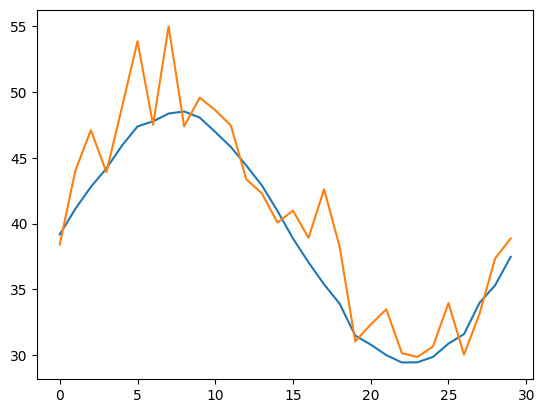

In [21]:
num = 10
plt.plot(y_hat_TFP[num])
plt.plot(y_test_TFP[num])

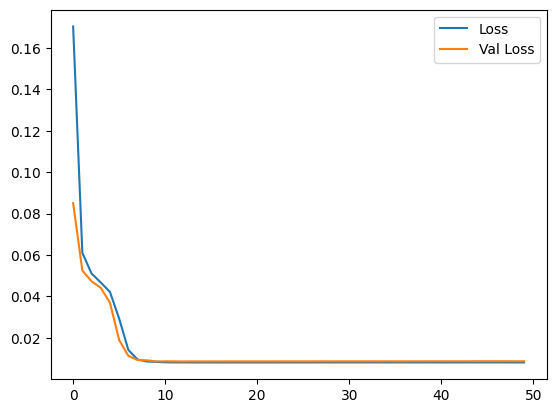

In [22]:

plt.plot(history_TFP.history['loss'][:],label = "Loss")
plt.plot(history_TFP.history['val_loss'][:],label = "Val Loss")
plt.legend()

## comparar TF con Normal

In [15]:
### abrir modelo sin ruido 

In [23]:
modelo = load_model('C:\\Users\\jd.pradal\\OneDrive - Universidad de los andes\\Documentos\\Maestría\\Tesis Maestría\\Modelos\\Datos Sintéticos\\1 frecuencia\\Archivos_Modelos_LSTM\\Seno_freq_30_amplitud_10_ruido3 Sin ruido_Modelo_150_nodos1_150_nodos2_70_Epocas_40_Batch_t_r_lvent120.keras')

y_hat_sinRuido, y_test_sinRuido,fecha_y_test_sinRuido,prediccion_sinRuido = Abrir_Modelo(datos,fechas,modelo,ventana,prediccion,size_test)

6/6 [==============================] - 1s 20ms/step


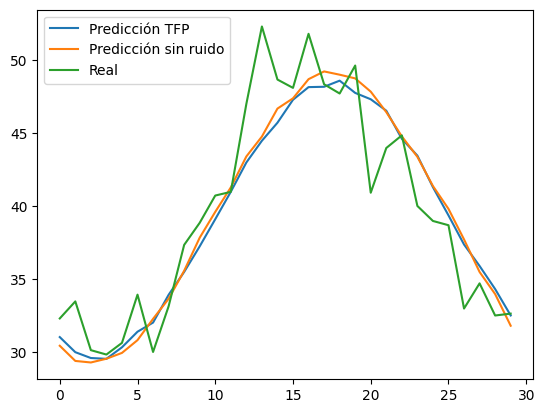

In [24]:
num = 30
plt.plot(y_hat_TFP[num],label = "Predicción TFP")
plt.plot(y_hat_sinRuido[num],label = "Predicción sin ruido")
plt.plot(y_test_TFP[num],label = "Real")
plt.legend()

In [25]:
NE_TFP

544.0

In [19]:
pip show tensorflow-privacy


Name: tensorflow-privacyNote: you may need to restart the kernel to use updated packages.

Version: 0.5.1
Summary: UNKNOWN
Home-page: https://github.com/tensorflow/privacy
Author: 
Author-email: 
License: Apache-2.0
Location: c:\Users\jd.pradal\OneDrive - Universidad de los andes\Documentos\Maestría\TESIS JUAN DIEGO PRADA\TFP05\venvtfp05\Lib\site-packages
Requires: dm-tree, mpmath, scipy, tensorflow-estimator
Required-by: 


In [20]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples = NE_TFP, # Aquí usamos 'num_examples' en lugar de 'n'
    batch_size=batch,
    noise_multiplier= ruido,
    delta=1e-5,
    num_epochs = epocas
)

print(f"Epsilon: {epsilon}")


ImportError: cannot import name 'compute_dp_sgd_privacy_statement' from 'tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib' (c:\Users\jd.pradal\OneDrive - Universidad de los andes\Documentos\Maestría\TESIS JUAN DIEGO PRADA\TFP05\venvtfp05\Lib\site-packages\tensorflow_privacy\privacy\analysis\compute_dp_sgd_privacy_lib.py)

In [ ]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy

# Parámetros correctos para la función
epsilon, _ = compute_dp_sgd_privacy(
    n=35430,               # Número total de ejemplos en el conjunto de datos
    batch_size=batch,      # Tamaño de cada lote o batch
    noise_multiplier=ruido, # Multiplicador de ruido usado en el optimizador DP
    epochs=epocas,         # Número de épocas de entrenamiento
    delta=1e-5             # Valor de delta, típico en privacidad diferencial
)

print(f"Epsilon: {epsilon}")


In [ ]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples=35430,   # Número total de ejemplos en el conjunto de datos
    batch_size=batch,           # Tamaño de cada lote
    noise_multiplier=ruido,     # Multiplicador de ruido usado en el optimizador DP
    delta=1e-5,                 # Delta para privacidad diferencial
    num_epochs=epocas           # Número de épocas de entrenamiento
)

print(f"Epsilon: {epsilon}")
